# This script aims to preprocess the data collected from the laboratory scaled rail break simulator

In [28]:
import Functions
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, stft



In [29]:
# adjust the plot text sizes to make figures readable
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [30]:
def collect_data(directory):
    data = []
    file_list = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            data.append(Functions.read_data_NI2(f))
            file_list.append(f)
    print(file_list)
    return data, file_list

def condition_data(data):
    for i in range(len(data)):
        data[i][0][:,0] = (data[i][0][:,0]+0.001)/(2.*9.81) # these values are sensor dependent
        data[i][0][:,1] = (data[i][0][:,1]-0.0194)/(2.007*9.81) # these values are sensor dependent
    return data

def ag_data(data):
    ag0 = 0
    ag1 = 0
    for d in data:
        ag0 = ag0 + d[0][:,0]
        ag1 = ag1 + d[0][:,1]
    ag0 = ag0/len(data)
    ag1 = ag1/len(data)
    return ag0, ag1

def time_to_space(data, vel):
    d = data[0]
    l = len(d[0][:,0])
    time=np.linspace(0,l-1,l)*0.001
    
    #Time to space domain
    gear_diam=0.09652 #m
    acc_spin=4.9
    total_spins=20.5
    top_speed = vel

    d_1=gear_diam*np.pi*acc_spin
    d_2=gear_diam*np.pi*(total_spins-acc_spin)
    d_3=gear_diam*np.pi*total_spins
    t_1=d_1*2/top_speed
    t_2=(d_2-d_1)/top_speed+t_1
    t_3=(d_3-d_2)*2/top_speed+t_2
    
    #Time difference adjustment
    t_diff=time[-1]-t_3
    t_1=t_1*(t_3+t_diff)/t_3
    t_2=t_2*(t_3+t_diff)/t_3
    t_3=t_3+t_diff
    adj_top_speed=d_3/(0.5*t_1+t_2-t_1+(t_3-t_2)*0.5)
    acc=adj_top_speed/t_1

    displacement=np.zeros(l)
    for i in range(l):
        if time[i]<t_1:
            displacement[i]=time[i]**2*acc*0.5
        elif time[i]>t_2:
            displacement[i]=d_2+((t_3-t_2)*adj_top_speed-(t_3-time[i])**2*acc)*0.5
        else:
            displacement[i]=d_1+(time[i]-t_1)*adj_top_speed
            
    return displacement*3.28084

def calc_fft(data_in):
    x0 = data_in[0][:,0]/(9.81*2)
    x1 = data_in[0][:,1]/(9.81*2)
    f0 = fft(data_in[0][:,0]/(9.81*2))
    f1 = fft(data_in[0][:,1]/(9.81*2))
    N = len(x0)
    n = np.arange(N)
    T = data_in[1]*N
    freq = n/T
    return f0, f1, freq, x0, x1

def calc_plot_fft(data):
    output = {
        'fft0':[],
        'fft1':[],
        'freq':[],
    }
    for d in data:
        f0, f1, freq, x0, x1 = calc_fft(d)
        output['fft0'].append(f0)
        output['fft1'].append(f1)
        output['freq'].append(freq)
        
    fft0_total = 0
    fft1_total = 0
    
    for i in output['fft0']:
        fft0_total = fft0_total+np.abs(i)
    for i in output['fft1']:
        fft1_total = fft1_total+np.abs(i)
        
    
    fft0_total = fft0_total/len(data)
    fft1_total = fft1_total/len(data)

        
    plt.figure(figsize = (12, 6))
    plt.plot(output['freq'][0][2:1000], np.abs(fft0_total[2:1000]))
    plt.plot(output['freq'][0][2:1000], np.abs(fft1_total[2:1000]))
    plt.xlim(0,100)
    plt.ylim(0,0.15)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(['Channel 0', 'Channel 1'])
    plt.show()
    
    plt.figure(figsize = (12, 6))
    plt.plot(output['freq'][0][2:1000], np.abs(fft0_total[2:1000]))
    plt.plot(output['freq'][0][2:1000], np.abs(fft1_total[2:1000]))
    plt.xlim(2,25)
    plt.ylim(0,0.15)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(['Channel 0', 'Channel 1'])
    plt.show()
    
    plt.figure(figsize = (12, 6))
    plt.plot(output['freq'][0][2:1000], np.abs(fft0_total[2:1000]))
    plt.plot(output['freq'][0][2:1000], np.abs(fft1_total[2:1000]))
    plt.xlim(50,80)
    plt.ylim(0,0.15)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(['Channel 0', 'Channel 1'])
    plt.show()
    
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def plot_unfiltered_filtered(time, ag, filtered):
    plt.figure(figsize = (12, 6))
    plt.plot(time[100:]*0.3048, ag[100:], label='unfiltered data', linewidth=2)
    plt.plot(time[100:]*0.3048, filtered[100:], label='filtered data, cutoff: 25hz', linewidth=1)
    plt.xlabel('Distance [m]')
    plt.ylabel("Acceleration [$m/s^2$]")
    plt.ylim(0.121,0.142)
    plt.legend()
    # plt.savefig('ag0_b_f.png',bbox_inches='tight')
    plt.show()
    


['4/run_n4__19.lvm', '4/run_n4__7.lvm', '4/run_n4__6.lvm', '4/run_n4__18.lvm', '4/run_n4__24.lvm', '4/run_n4__4.lvm', '4/run_n4__5.lvm', '4/run_n4__23.lvm', '4/run_n4__1.lvm', '4/run_n4__0.lvm', '4/run_n4__22.lvm', '4/run_n4__20.lvm', '4/run_n4__2.lvm', '4/run_n4__3.lvm', '4/run_n4__21.lvm', '4/run_n4__10.lvm', '4/run_n4__11.lvm', '4/run_n4__13.lvm', '4/run_n4__12.lvm', '4/run_n4__16.lvm', '4/run_n4__8.lvm', '4/run_n4__9.lvm', '4/run_n4__17.lvm', '4/run_n4__15.lvm', '4/run_n4__14.lvm']


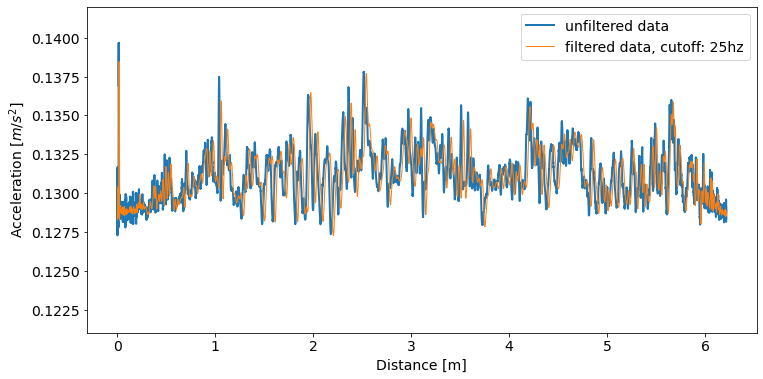

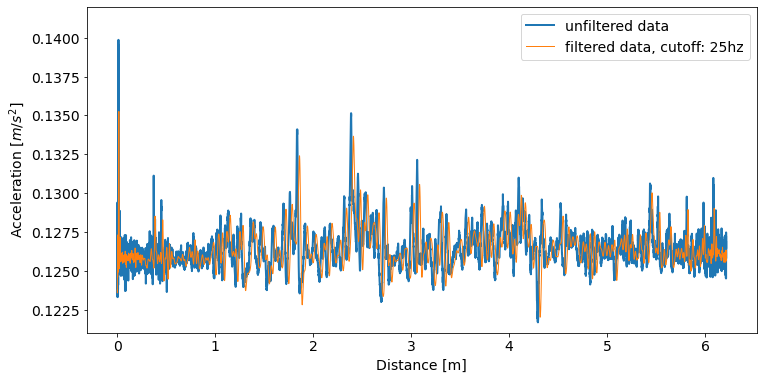

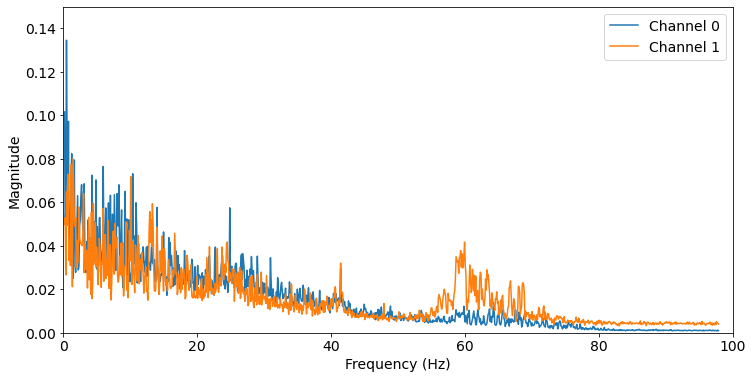

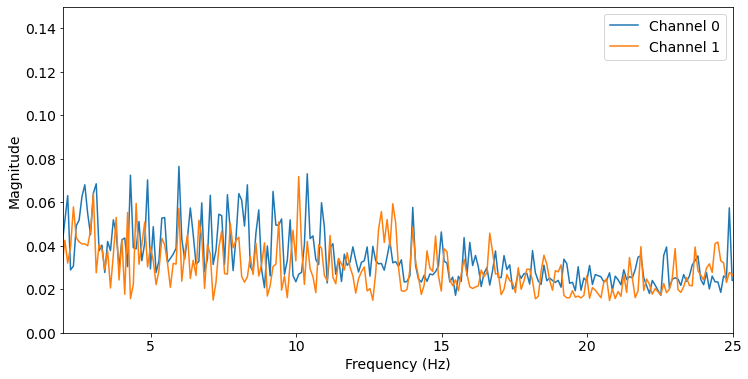

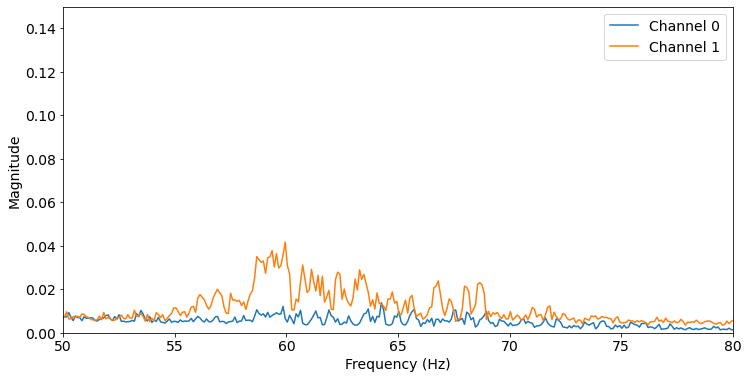

['11/run_n11__8.lvm', '11/run_n11__9.lvm', '11/run_n11__2.lvm', '11/run_n11__3.lvm', '11/run_n11__1.lvm', '11/run_n11__0.lvm', '11/run_n11__4.lvm', '11/run_n11__5.lvm', '11/run_n11__7.lvm', '11/run_n11__6.lvm']


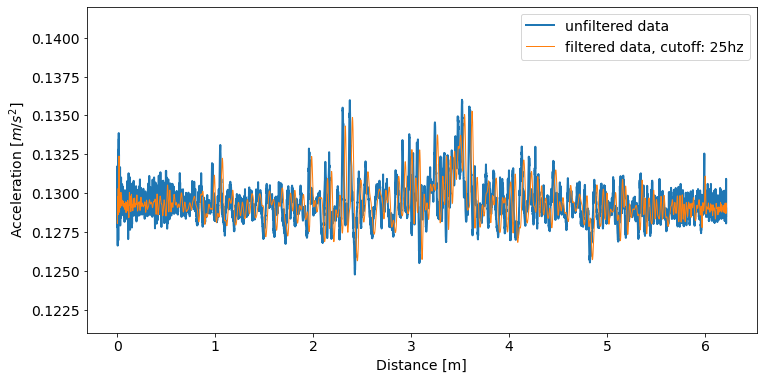

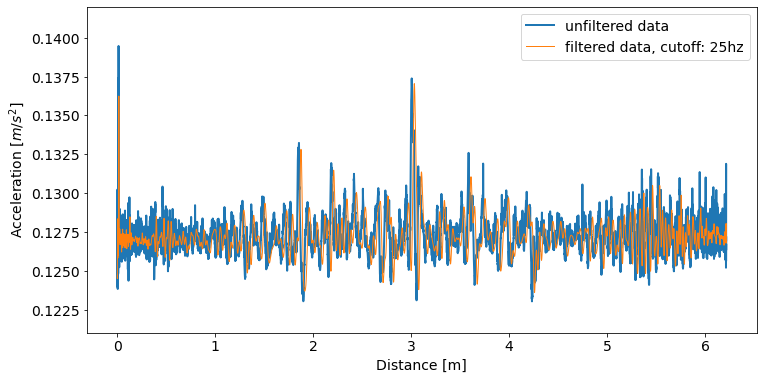

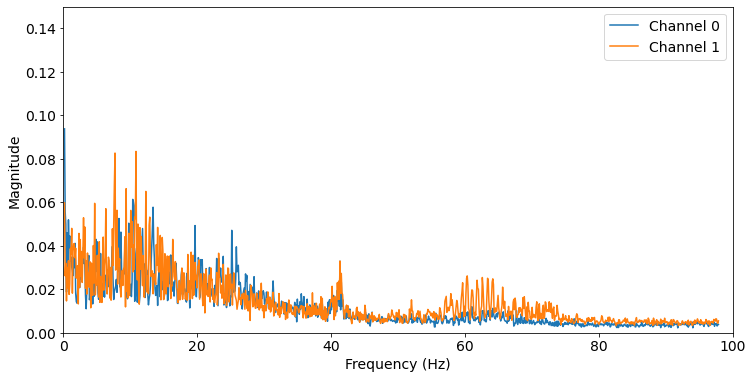

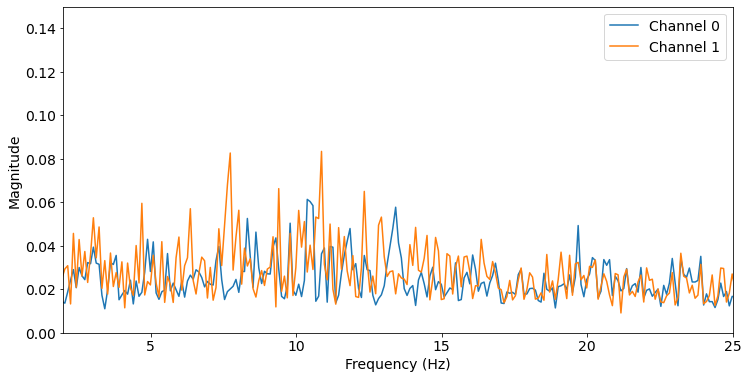

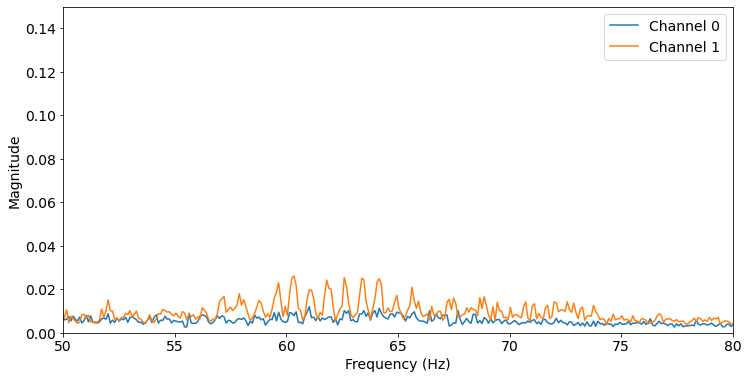

['44/run_n44__9.lvm', '44/run_n44__8.lvm', '44/run_n44__3.lvm', '44/run_n44__2.lvm', '44/run_n44__0.lvm', '44/run_n44__1.lvm', '44/run_n44__5.lvm', '44/run_n44__4.lvm', '44/run_n44__6.lvm', '44/run_n44__7.lvm']


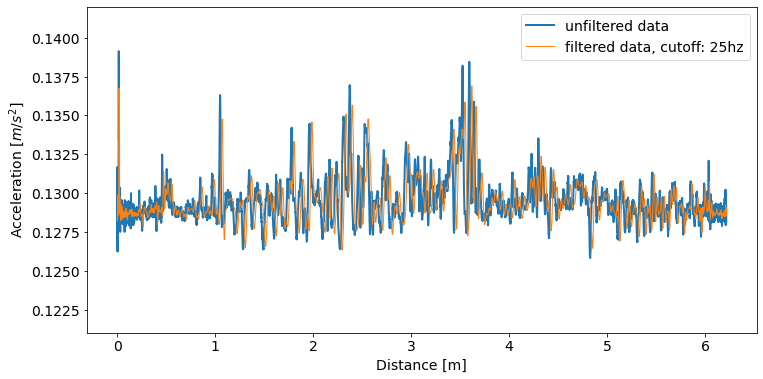

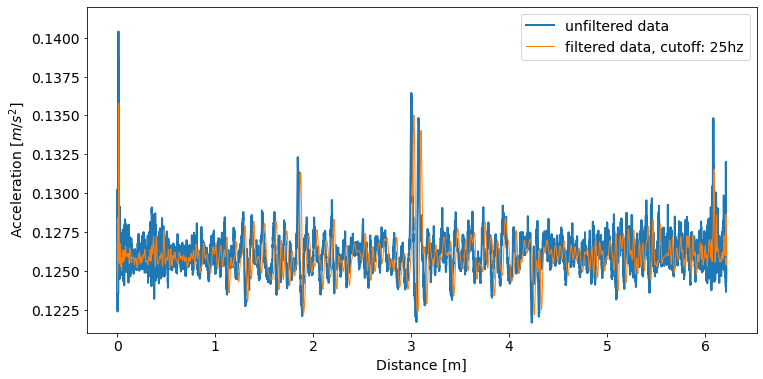

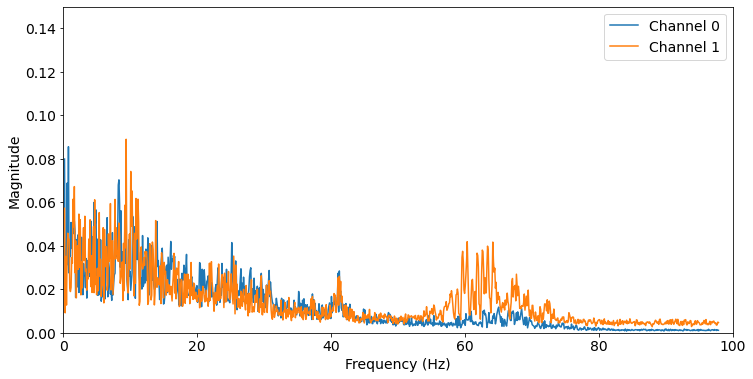

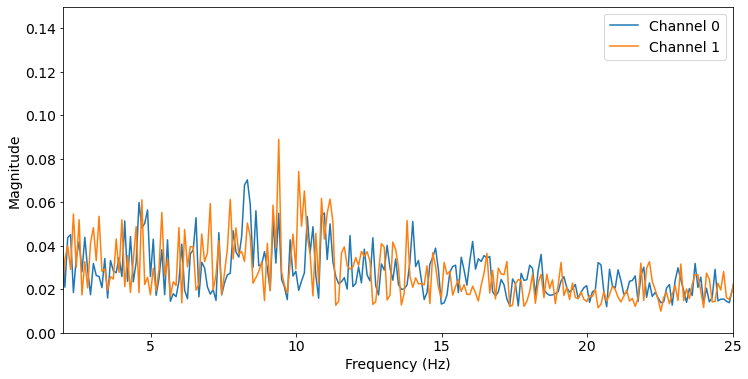

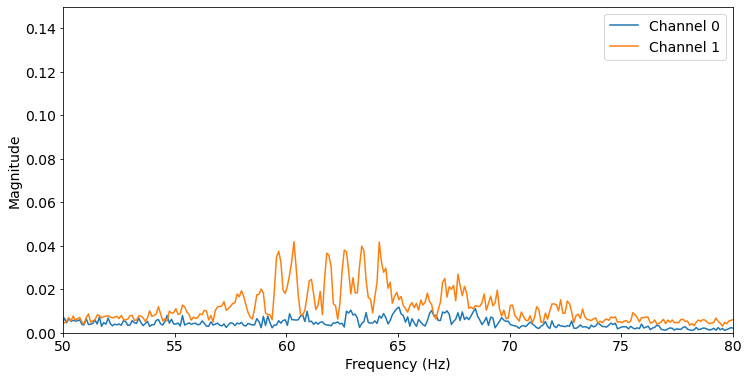

['6/run_n6__23.lvm', '6/run_n6__22.lvm', '6/run_n6__20.lvm', '6/run_n6__21.lvm', '6/run_n6__19.lvm', '6/run_n6__24.lvm', '6/run_n6__18.lvm', '6/run_n6__2.lvm', '6/run_n6__3.lvm', '6/run_n6__1.lvm', '6/run_n6__0.lvm', '6/run_n6__4.lvm', '6/run_n6__5.lvm', '6/run_n6__7.lvm', '6/run_n6__6.lvm', '6/run_n6__8.lvm', '6/run_n6__9.lvm', '6/run_n6__16.lvm', '6/run_n6__17.lvm', '6/run_n6__15.lvm', '6/run_n6__14.lvm', '6/run_n6__10.lvm', '6/run_n6__11.lvm', '6/run_n6__13.lvm', '6/run_n6__12.lvm']


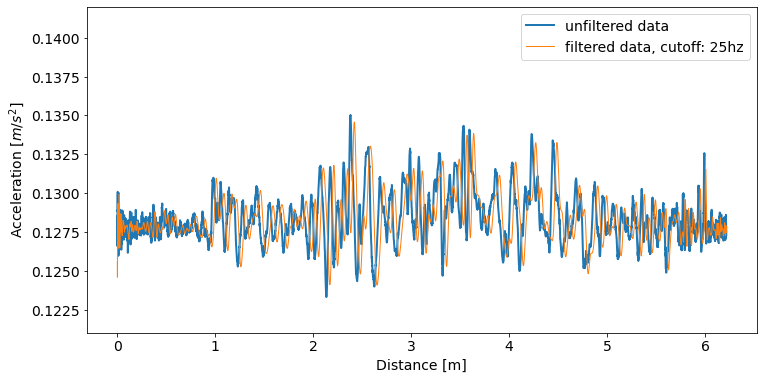

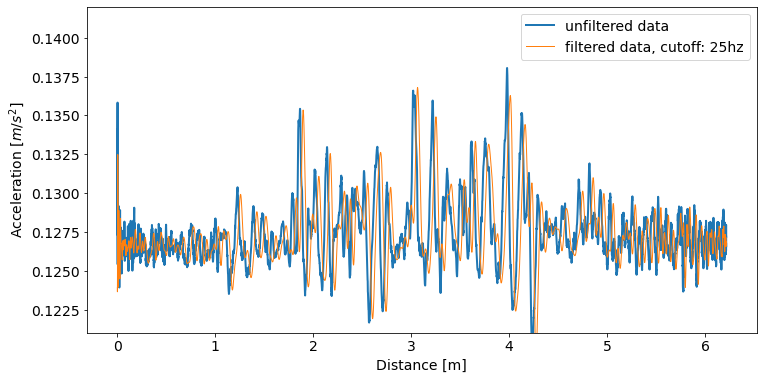

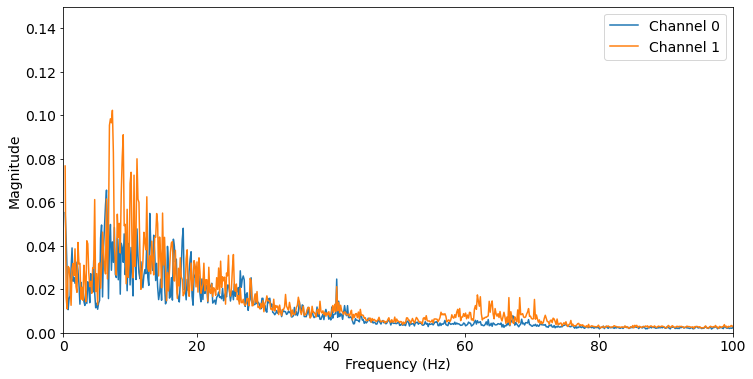

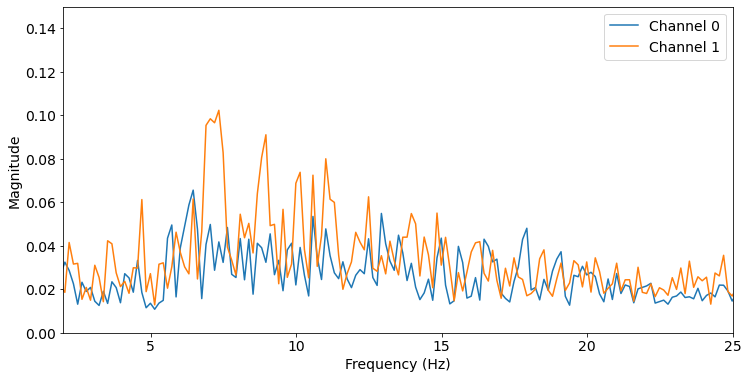

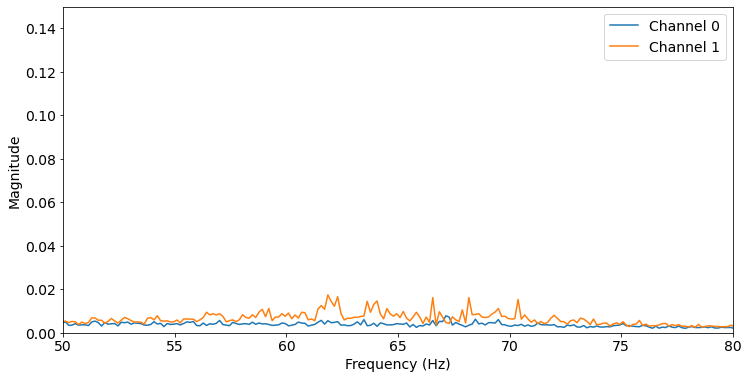

['16/run_n16__2.lvm', '16/run_n16__3.lvm', '16/run_n16__1.lvm', '16/run_n16__0.lvm', '16/run_n16__4.lvm', '16/run_n16__5.lvm', '16/run_n16__7.lvm', '16/run_n16__6.lvm', '16/run_n16__8.lvm', '16/run_n16__9.lvm']


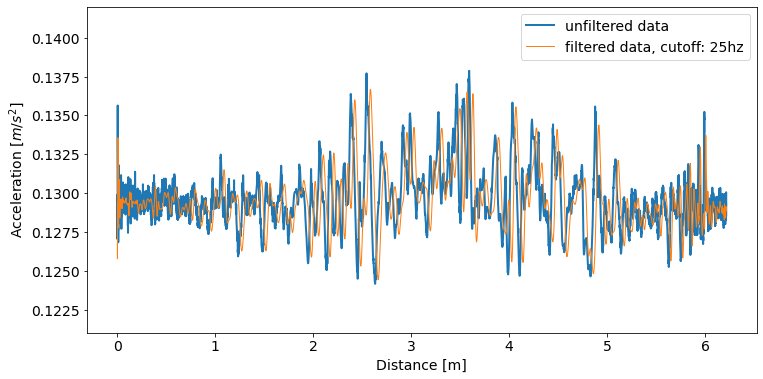

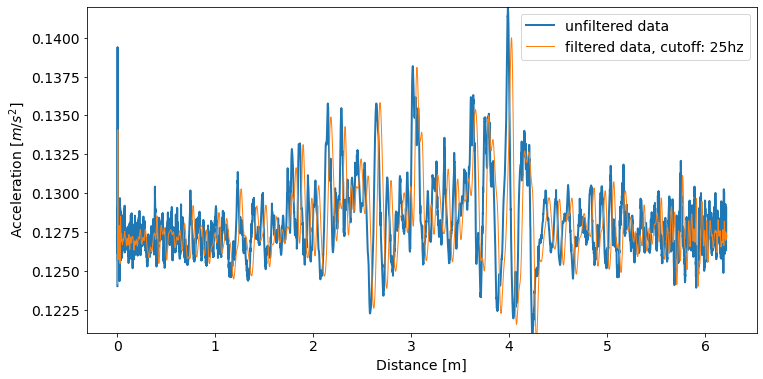

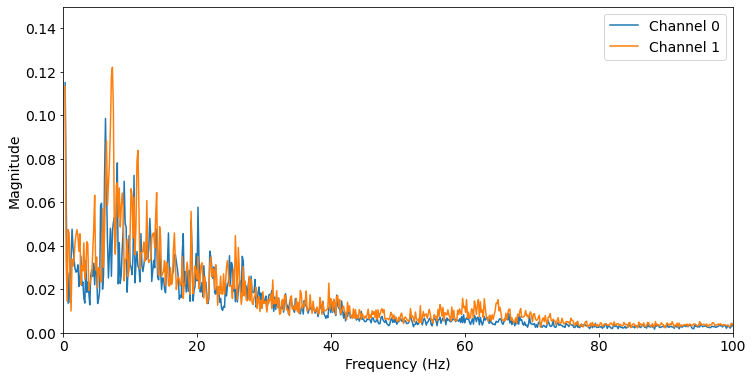

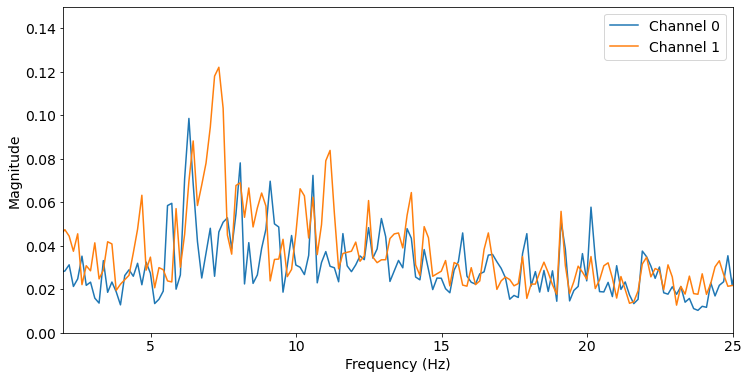

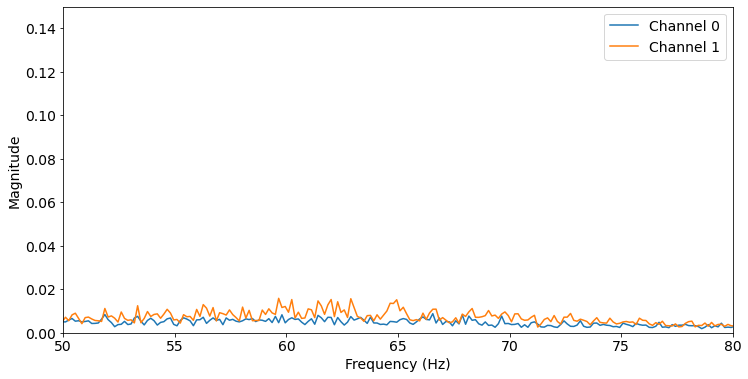

['49/run_n49__1.lvm', '49/run_n49__0.lvm', '49/run_n49__2.lvm', '49/run_n49__3.lvm', '49/run_n49__7.lvm', '49/run_n49__6.lvm', '49/run_n49__4.lvm', '49/run_n49__5.lvm', '49/run_n49__8.lvm', '49/run_n49__9.lvm']


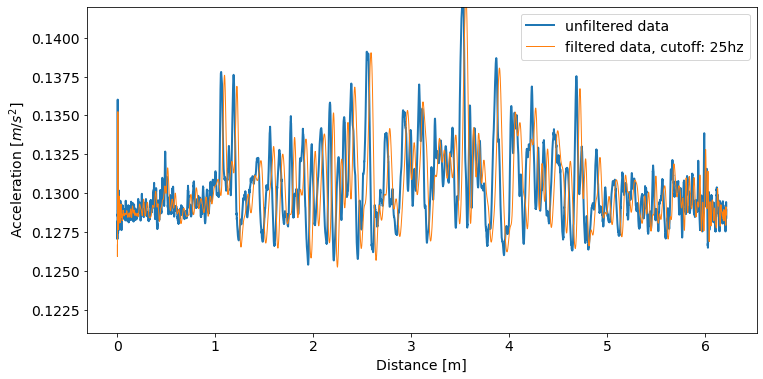

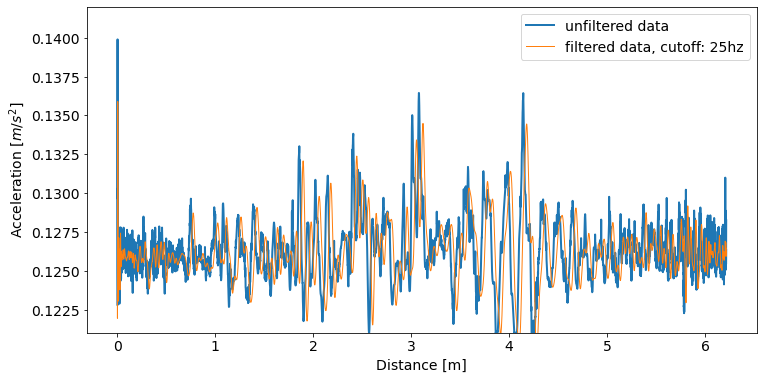

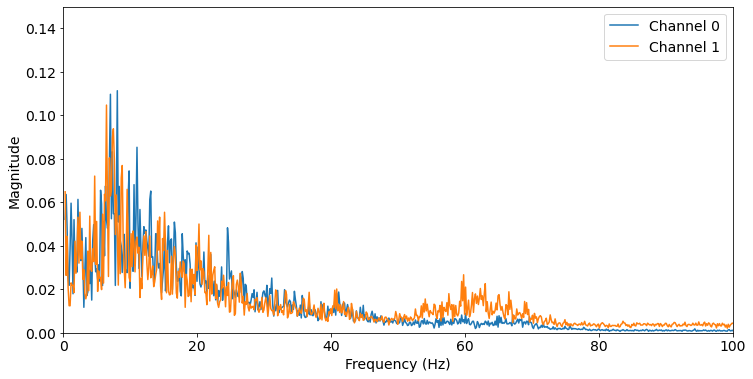

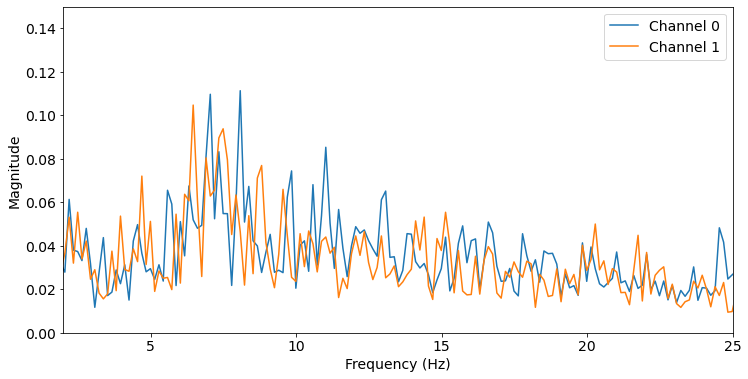

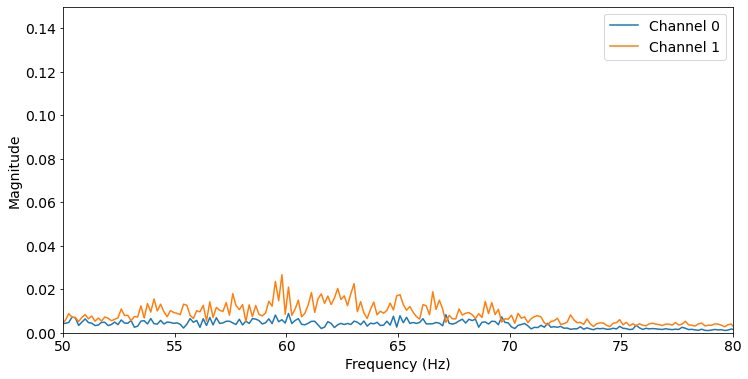

In [31]:
# Each damage type was placed into a folder with multiple repeated runs.
# The subdirectories were placed in the current working directory and listed here
DIRECTORY = [
    '4','11','44','6','16','49'
]

# The corrosponding peak velocites are listed here and used in the time to space domain calculations
PEAK_VELOCITIES = [
    0.9,0.9,0.9,1.35,1.35,1.35
]

for dir in range(len(DIRECTORY)): # iterate though all of the damge types
    data, file_list = collect_data(DIRECTORY[dir]) # read data
    data = condition_data(data) # convert data based on sensor characteristics
    ag0, ag1 = ag_data(data) # aggregate data
    
    time = time_to_space(data, PEAK_VELOCITIES[dir]) # convert X-axis from time to space
    y0 = butter_lowpass_filter(ag0, 25, 1000, 6) # filter data for channel 0
    y1 = butter_lowpass_filter(ag1, 25, 1000, 6) # filter data for channel 1
    
    # plot filtered data
    plot_unfiltered_filtered(time, ag0, y0)
    plot_unfiltered_filtered(time, ag1, y1)
    
    # plot fft
    calc_plot_fft(data)
